# Loading libraries and dataset

In [111]:
from models.model import CLIPModel
from models.utils import train_step, eval_step, DataLoaders
from models.transforms import transforms_vit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import timm
transform = transforms.Compose([
    transforms.ToTensor()
])

train = CIFAR10(root='data', train=True, download=True, transform=transform)
test = CIFAR10(root='data', train=False, download=True, transform=transform)
BATCH_SIZE = 64
N_EPOCHS = 3
dl = DataLoaders(train,test,'clip',BATCH_SIZE,True,'cifar10')
train_loader, test_loader = dl.get_loaders()


Files already downloaded and verified
Files already downloaded and verified


Loading image and text encoders for `CLIP`.

In [112]:
model = CLIPModel(256)
model.image_encoder.load_state_dict(torch.load("clip_image_encoder_cifar10.pth", map_location=torch.device('cpu')))
model.text_encoder.load_state_dict(torch.load("clip_text_encoder_cifar10.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Building concept dictionary, with CIFAR-10 classes as concepts.

In [113]:
classes_small = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
classes_large = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 
 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 
 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 
 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 
 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 
 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 
 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 
 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm', "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
concept_dictionary_s = []
concept_dictionary_l = []
for caption in classes_small:
  encoded_captions = tokenizer(caption, padding=True, truncation=True, return_tensors='pt')
  encoded_captions =  {key: torch.tensor(values) for key, values in encoded_captions.items()}
  input_ids = encoded_captions['input_ids']
  attn_mask = encoded_captions['attention_mask']
  text_emb = model.text_encoder(input_ids=input_ids,attention_mask=attn_mask)
  concept_dictionary_s.append(text_emb)
for caption in classes_large:
  encoded_captions = tokenizer(caption, padding=True, truncation=True, return_tensors='pt')
  encoded_captions =  {key: torch.tensor(values) for key, values in encoded_captions.items()}
  input_ids = encoded_captions['input_ids']
  attn_mask = encoded_captions['attention_mask']
  text_emb = model.text_encoder(input_ids=input_ids,attention_mask=attn_mask)
  concept_dictionary_l.append(text_emb)

C:\Users\mshum\AppData\Local\Temp\ipykernel_10208\3322283239.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_captions =  {key: torch.tensor(values) for key, values in encoded_captions.items()}
C:\Users\mshum\AppData\Local\Temp\ipykernel_10208\3322283239.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_captions =  {key: torch.tensor(values) for key, values in encoded_captions.items()}


Embedding 10 images per class from CIFAR-10. Ten images per class and total ten classes, meaning `image_embeddings` will have 100 images.

In [114]:
image_embeddings = []
true_labels = []
class_images = {i: [] for i in range(10)}
resize_transform = transforms.Resize((224, 224))
counts_per_class = {i: 0 for i in range(10)}
images = []
for img, label in train:
    if counts_per_class[label] < 10:
        resized_img = resize_transform(img).unsqueeze(0)
        class_images[label].append(resized_img)
        counts_per_class[label] += 1

    if all(count == 10 for count in counts_per_class.values()):
        break
for label, image_list in class_images.items():
    for image in image_list:
        images.append(image)
        image_emb = model.image_encoder(image)
        image_embeddings.append(image_emb)
        true_labels.append(label)

C:\Users\mshum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Centering and normalizing dictionary and image embeddings

In [115]:
# ################ Image ################################
stacked_embeddings_img = torch.stack(image_embeddings)
stacked_embeddings_img = stacked_embeddings_img.squeeze(1)
u_img = torch.mean(stacked_embeddings_img, dim=0)
aligned_img_embeddings = stacked_embeddings_img - u_img
z_img = stacked_embeddings_img
std_img = torch.std(stacked_embeddings_img, dim=0, keepdim=True)  # Shape: [1, 256]
zc = aligned_img_embeddings / std_img

# ################ Dictionary ###########################
stacked_embeddings_concept = torch.stack(concept_dictionary_l)
stacked_embeddings_concept = stacked_embeddings_concept.squeeze(1)
uc_l = torch.mean(stacked_embeddings_concept, dim=0)
aligned_concept_embeddings = stacked_embeddings_concept - uc
A_l = stacked_embeddings_concept
std_img = torch.std(stacked_embeddings_img, dim=0, keepdim=True)
Ac_l = aligned_concept_embeddings / std_img

stacked_embeddings_concept = torch.stack(concept_dictionary_s)
stacked_embeddings_concept = stacked_embeddings_concept.squeeze(1)
uc_s = torch.mean(stacked_embeddings_concept, dim=0)
aligned_concept_embeddings = stacked_embeddings_concept - uc
A_s = stacked_embeddings_concept
std_img = torch.std(stacked_embeddings_img, dim=0, keepdim=True)
Ac_s = aligned_concept_embeddings / std_img



Implementing `ISTA` function for solving sparse vector `w`

In [116]:
def soft_thresholding(x, alpha):
    return torch.sign(x) * torch.maximum(torch.abs(x) - alpha, torch.zeros_like(x))

def ista(Ac, zc, lambda_, max_iter, eta):
    tol=1e-6
    w = torch.zeros(Ac.shape[1])

    for k in range(max_iter):
        grad_w = Ac.T @ (Ac @ w - zc)
        w_next = w - eta * grad_w
        w_next = soft_thresholding(w_next, lambda_ * eta)
        if torch.norm(w_next - w) < tol:
            break
        w = w_next

    return w

Functions for zero-shot classification by computing `cosine_similarity` of concept dictionary with both `z_dense` and `z_sparse`.

In [117]:
def compute_cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()

def zero_shot_classification(z_dense, z_sparse):
    dense_similarities = []
    sparse_similarities = []
    for concept_embedding in Ac_s:
        sim = compute_cosine_similarity(z_dense, concept_embedding)
        dense_similarities.append(sim)
        sim = compute_cosine_similarity(z_sparse, concept_embedding)
        sparse_similarities.append(sim)

    predicted_dense_class = torch.argmax(torch.tensor(dense_similarities)).item()
    predicted_sparse_class = torch.argmax(torch.tensor(sparse_similarities)).item()

    return predicted_dense_class, predicted_sparse_class

Performing zero-shot classification on both z_sparse and z_dense and reporting accuracy of both of their performances.

In [118]:
dense_acc = []
sparse_acc = []
# Ac => centralized & normalized dictionary
# z_dense => one centralized & normalized image
for index, z_dense in enumerate(zc):
  w = ista(Ac_l.T, z_dense, lambda_ = 0.05, max_iter=100, eta=0.01)

  z_hat_img = A_l.T @ w
  z_sparse = z_hat_img + uc_l

  predicted_dense_class, predicted_sparse_class = zero_shot_classification(z_dense, z_sparse)
  # print("dense: ", predicted_dense_class, " sparse: ", predicted_sparse_class, " true: ", true_labels[index])
  if predicted_sparse_class == true_labels[index]: sparse_acc.append(1)
  else: sparse_acc.append(0)
  if predicted_dense_class == true_labels[index]: dense_acc.append(1)
  else: dense_acc.append(0)
print("Predicted Dense Class Accuracy:", sum(dense_acc)/len(dense_acc))
print("Predicted Sparse Class Accuracy:", sum(sparse_acc)/len(sparse_acc))

Predicted Dense Class Accuracy: 0.92
Predicted Sparse Class Accuracy: 0.88


Plotting relationship of sparsity of embeddings and their corresponding accuracies, by varying lambda.

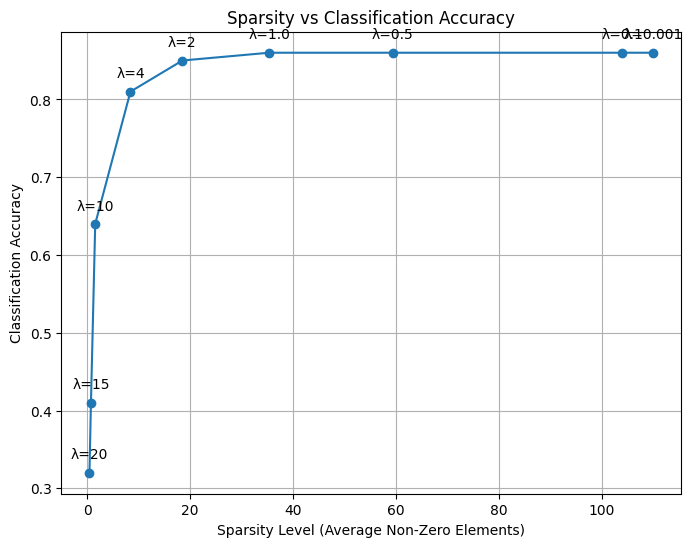

In [119]:
def count_non_zero_elements(tensor):
    return (tensor != 0).sum().item()

lambda_values = [0.001, 0.1, 0.5, 1.0, 2, 4, 10, 15, 20]

accuracies = []
sparsity_levels = []

for lambda_ in lambda_values:
    correct_predictions = 0
    total_images = len(zc)

    non_zero_counts = []

    for index, z_dense in enumerate(zc):
        w = ista(Ac_l.T, z_dense, lambda_ = lambda_, max_iter=100, eta=0.01)
        z_sparse = Ac_l.T @ w + uc_l

        non_zero_counts.append(count_non_zero_elements(w))

        predicted_dense_class, predicted_sparse_class = zero_shot_classification(z_dense, z_sparse)

        if predicted_sparse_class == true_labels[index]:
            correct_predictions += 1

    accuracy = correct_predictions / total_images
    average_non_zero = sum(non_zero_counts) / total_images

    accuracies.append(accuracy)
    sparsity_levels.append(average_non_zero)

plt.figure(figsize=(8, 6))
plt.plot(sparsity_levels, accuracies, marker='o')

for i, lambda_ in enumerate(lambda_values):
    plt.annotate(f'λ={lambda_}', (sparsity_levels[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Sparsity Level (Average Non-Zero Elements)')
plt.ylabel('Classification Accuracy')
plt.title('Sparsity vs Classification Accuracy')
plt.grid(True)
plt.show()

Comparing memory for both dense and sparse embeddings.

In [120]:
def memory_footprint(tensor):
    return tensor.element_size() * tensor.nelement()

total_dense_memory = 0
total_sparse_memory = 0

for z_dense in zc:
    total_dense_memory += memory_footprint(z_dense)
    
    w = ista(Ac_s.T, z_dense, lambda_=0.1, max_iter=100, eta=0.01)
    z_sparse = Ac_s.T @ w + uc_s
    
    sparse_non_zero = w[w != 0]
    total_sparse_memory += memory_footprint(sparse_non_zero)

print(f"Total memory footprint of dense embeddings: {total_dense_memory} bytes")
print(f"Total memory footprint of sparse embeddings: {total_sparse_memory} bytes")

Total memory footprint of dense embeddings: 102400 bytes
Total memory footprint of sparse embeddings: 3972 bytes


Analyzing most active concepts in a few examples of zero-shot classification.

In [130]:

image_and_concepts = []
for i, z_dense in enumerate(zc):
    w = ista(Ac_l.T, z_dense, lambda_=0.1, max_iter=100, eta=0.01)
    non_zero_indices = torch.nonzero(w).squeeze()
    concept_weights = [(classes_large[idx.item()], w[idx].item()) for idx in non_zero_indices]
    sorted_concepts = sorted(concept_weights, key=lambda x: x[1], reverse=True)

    # Take the top 3 concepts
    top_3_concepts = sorted_concepts[:3]
    image_and_concepts.append({
        'index': i,
        'top_concepts': top_3_concepts,
        'image': images[i]
    })

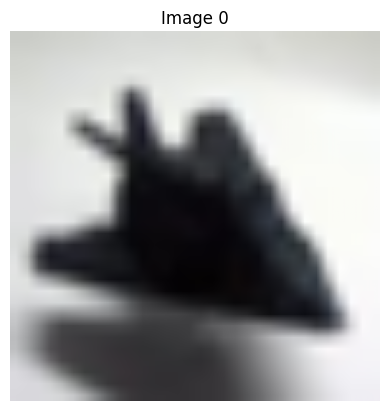

Image 0: Top 3 Contributing Concepts
fox: 1.78
Airplane: 1.76
whale: 1.51




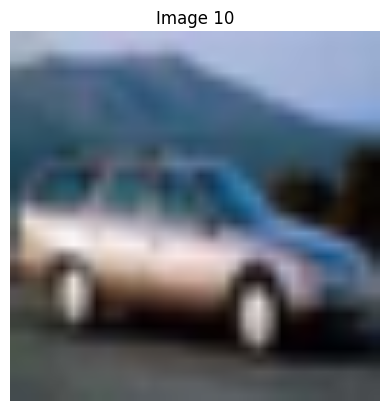

Image 10: Top 3 Contributing Concepts
Automobile: 3.50
streetcar: 1.47
aquarium_fish: 0.89




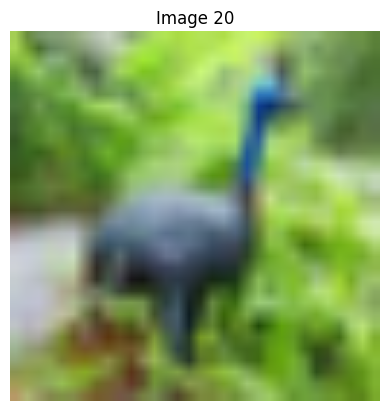

Image 20: Top 3 Contributing Concepts
Bird: 1.91
bee: 1.32
bridge: 1.18




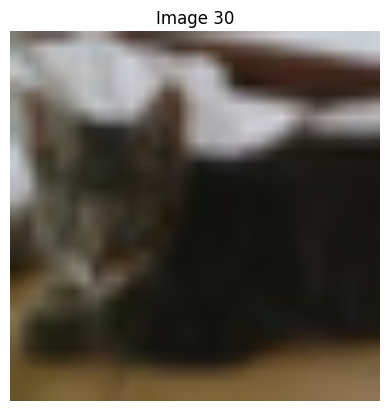

Image 30: Top 3 Contributing Concepts
Cat: 0.95
hamster: 0.79
leopard: 0.79




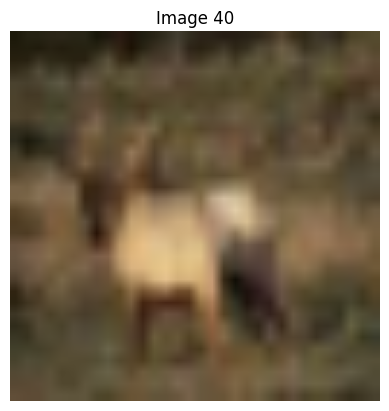

Image 40: Top 3 Contributing Concepts
Deer: 2.33
Ship: 0.84
tiger: 0.82




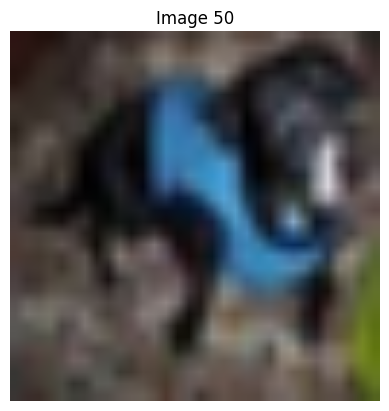

Image 50: Top 3 Contributing Concepts
Dog: 1.88
boy: 1.35
mushroom: 1.27




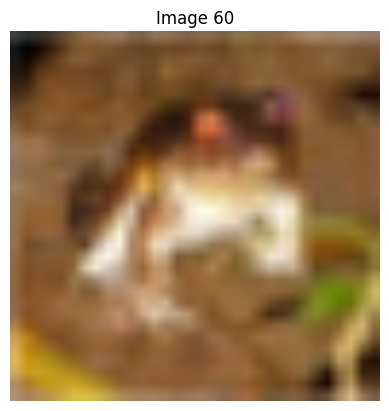

Image 60: Top 3 Contributing Concepts
Frog: 1.80
skunk: 1.40
telephone: 1.30




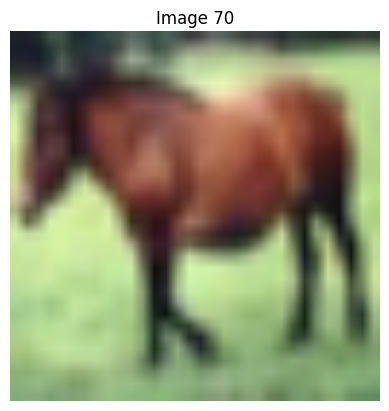

Image 70: Top 3 Contributing Concepts
Horse: 1.59
wardrobe: 1.00
hamster: 0.73




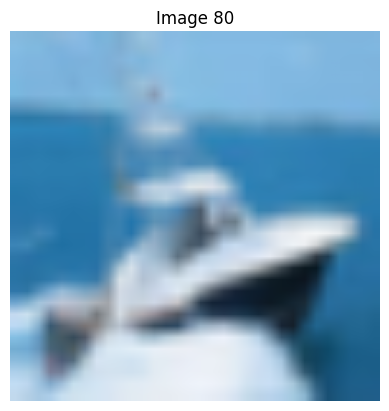

Image 80: Top 3 Contributing Concepts
Ship: 2.83
whale: 1.35
leopard: 1.32




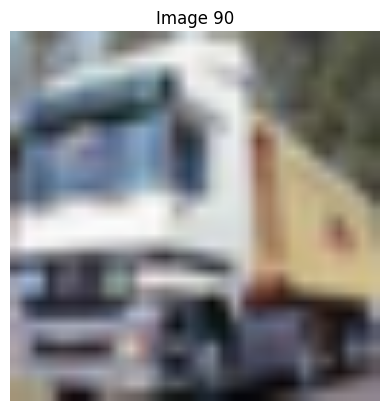

Image 90: Top 3 Contributing Concepts
Truck: 1.74
pickup_truck: 1.35
tank: 0.70




In [122]:
for i in range(0, len(image_and_concepts), 10):    
    example = image_and_concepts[i]
    img = example['image']
    
    if img.dim() == 4:
        img = img.squeeze(0)

    img = img.permute(1, 2, 0).cpu().numpy()
    top_concepts = example['top_concepts']

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {example['index']}")
    plt.show()
    print(f"Image {example['index']}: Top 3 Contributing Concepts")
    for concept, weight in top_concepts:
        print(f"{concept}: {weight:.2f}")
    print("\n")

#### By observing the above examples, we can get a clear correlation between the actual image and the concepts with the highest `w` values for it, and except for our first printed image example, all others have a clear and convincing label for `w`, with some examples such as the last having similar concepts lining up behind the true concept, **for eg. Image 90 which is a picture of a truck has Truck, pickup_truck and tank in the following order as the top 3 active concepts for its pridiction.***